<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Train-of-thought" data-toc-modified-id="Train-of-thought-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train of thought</a></span></li><li><span><a href="#Get-S&amp;P-500-composition-change-history" data-toc-modified-id="Get-S&amp;P-500-composition-change-history-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get S&amp;P 500 composition change history</a></span></li><li><span><a href="#Constructing-the-portfolio-from-historic-date-to-now" data-toc-modified-id="Constructing-the-portfolio-from-historic-date-to-now-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Constructing the portfolio from historic date to now</a></span><ul class="toc-item"><li><span><a href="#Let's-get-started" data-toc-modified-id="Let's-get-started-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Let's get started</a></span></li><li><span><a href="#Get-current-S&amp;P-500-composition" data-toc-modified-id="Get-current-S&amp;P-500-composition-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Get current S&amp;P 500 composition</a></span></li><li><span><a href="#Exam-the-results-when-constructing-the-S&amp;P-500-composition-from-history" data-toc-modified-id="Exam-the-results-when-constructing-the-S&amp;P-500-composition-from-history-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exam the results when constructing the S&amp;P 500 composition from history</a></span></li></ul></li><li><span><a href="#Reverse:-We-construct-the-S&amp;P-500-composition-from-present-day-to-before" data-toc-modified-id="Reverse:-We-construct-the-S&amp;P-500-composition-from-present-day-to-before-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reverse: We construct the S&amp;P 500 composition from present day to before</a></span><ul class="toc-item"><li><span><a href="#Let's-build-the-composition-of-S&amp;P-500-from-bottom-up" data-toc-modified-id="Let's-build-the-composition-of-S&amp;P-500-from-bottom-up-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Let's build the composition of S&amp;P 500 from bottom up</a></span></li></ul></li><li><span><a href="#How-to-build-your-historic-S&amp;P-500-composition" data-toc-modified-id="How-to-build-your-historic-S&amp;P-500-composition-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>How to build your historic S&amp;P 500 composition</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

## Train of thought
First of all, I gotta say I'm a stingy guy. Even though there are paid resources that we're able to get according to [The S&P 500 Historical Components & Changes](https://analyzingalpha.com/sp500-historical-components-and-changes), I'm still inclining to use free resources to construct my own data source.

After reading [The S&P 500 Historical Components & Changes](https://analyzingalpha.com/sp500-historical-components-and-changes), I considered that the result that we've got from this article is not enough as we need the composition of the S&P 500 over time. After found a json file in [The S&P 500 Historical Components & Changes](https://analyzingalpha.com/sp500-historical-components-and-changes), which is already a list that we desired. But it is limited from `2008`~`2019`, I'm going to use this list and the changes in the original article to build the list we need further.

**Methodology**

I'm going to use the list provided in the json file, and then use the changelog that we extracted from the S&P 500 wiki page to update the S&P 500 composition over time.

## Get S&P 500 composition change history
Context: [The S&P 500 Historical Components & Changes](https://analyzingalpha.com/sp500-historical-components-and-changes)

Let's start with following this article to get the changelog over time

In [405]:
import pandas as pd
from datetime import datetime
import numpy as np
import requests
import datetime

In [318]:
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500 = data[0].iloc[1:,[0,1,6,7]]
sp500

,Symbol,Security,Date first added,CIK
1,ABT,Abbott Laboratories,1964-03-31,1800
2,ABBV,AbbVie Inc.,2012-12-31,1551152
3,ABMD,Abiomed,2018-05-31,815094
4,ACN,Accenture plc,2011-07-06,1467373
5,ATVI,Activision Blizzard,2015-08-31,718877
...,...,...,...,...
500,YUM,Yum! Brands Inc,1997-10-06,1041061
501,ZBRA,Zebra Technologies,2019-12-23,877212
502,ZBH,Zimmer Biomet,2001-08-07,1136869
503,ZION,Zions Bancorp,2001-06-22,109380


In [319]:
# Get current S&P table and set header column
sp500 = data[0].iloc[1:,[0,1,6,7]]
columns = ['added_ticker', 'name', 'date', 'cik']
sp500.columns = columns
sp500.loc[sp500['date'].isnull(), 'date'] = '1957-01-01'

# One date is in the wrong format. Correcting it.
sp500.loc[:,'date'] = sp500.loc[:,'date'].apply(lambda x: datetime.strptime(x[:10],'%Y-%m-%d'))
sp500 = pd.melt(sp500, id_vars=['date', 'name', 'cik'], value_vars=['added_ticker'])
sp500.head()

,date,name,cik,variable,value
0,1964-03-31,Abbott Laboratories,1800,added_ticker,ABT
1,2012-12-31,AbbVie Inc.,1551152,added_ticker,ABBV
2,2018-05-31,Abiomed,815094,added_ticker,ABMD
3,2011-07-06,Accenture plc,1467373,added_ticker,ACN
4,2015-08-31,Activision Blizzard,718877,added_ticker,ATVI


In [320]:
# Get S&P500 adjustments table and set columns
sp500_adjustments = data[1]
sp500_adjustments = sp500_adjustments[2:].copy()
columns = ['date', 'added_ticker', 'added_name', 'removed_ticker', 'removed_name', 'reason']
sp500_adjustments.columns = columns
updates = sp500_adjustments[~sp500_adjustments['date'].str.contains(',')].T.shift(1).T
sp500_adjustments['date'].loc[~sp500_adjustments['date'].str.contains(',')] = np.nan
sp500_adjustments[sp500_adjustments['added_ticker'].isnull()]
sp500_adjustments.update(updates)
sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
sp500_additions = sp500_adjustments[~sp500_adjustments['added_ticker'].isnull()]
sp500_additions = sp500_additions[['date', 'added_ticker', 'added_name']]
sp500_additions.rename(columns={'added_name': 'name'}, inplace=True)
sp500_additions = pd.melt(sp500_additions, id_vars=['date','name'], value_vars=['added_ticker'])
sp500_deletions = sp500_adjustments[~sp500_adjustments['removed_ticker'].isnull()]
sp500_deletions = sp500_deletions[['date', 'removed_ticker', 'removed_name']]
sp500_deletions.rename(columns={'removed_name': 'name'}, inplace=True)
sp500_deletions = pd.melt(sp500_deletions, id_vars=['date','name'], value_vars=['removed_ticker'])
sp500_history = pd.concat([sp500_deletions, sp500_additions])
sp500_history.head()

,date,name,variable,value
0,"December 21, 2020",Apartment Investment & Management,removed_ticker,AIV
1,"October 12, 2020",Noble Energy,removed_ticker,NBL
2,"October 7, 2020",E*TRADE Financial,removed_ticker,ETFC
3,"September 21, 2020",H&R Block,removed_ticker,HRB
4,"September 21, 2020",Coty Inc.,removed_ticker,COTY


In [321]:
df = pd.concat([sp500, sp500_history], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='cik', ascending=False, inplace=True)
deduped_df = df[~df.duplicated(['date', 'variable', 'value'])].copy()
deduped_df.sort_values(by='date',inplace=True)
deduped_df.to_csv("sp500_history.csv")
deduped_df.head()

,date,name,cik,variable,value
373,1957-01-01,PPL Corp.,922224.0,added_ticker,PPL
120,1957-01-01,Consolidated Edison,1047862.0,added_ticker,ED
402,1957-01-01,S&P Global Inc.,64040.0,added_ticker,SPGI
389,1957-01-01,Raytheon Technologies,101829.0,added_ticker,RTX
321,1957-01-01,Moody's Corp,1059556.0,added_ticker,MCO


So far, we have successfully extracted the changelog we need from the S&P 500 Wikipedia page. We can examine the added symbol and removed symbol with the following code:

In [337]:
x = deduped_df.sort_values(['date', 'variable']).set_index(['date', 'variable'])

In [338]:
x.loc[pd.to_datetime('1999-12-07'), :]

,name,cik,value
variable,,,
added_ticker,Yahoo!,NaN,YHOO
removed_ticker,Laidlaw,NaN,LDW


---

## Constructing the portfolio from historic date to now
Context: [Some other people prepared this json file of S&P 500 historic composition](https://gist.github.com/kafkasl/078f2c65c4299d367b57c9835b34c333)

### Let's get started
Now, we're going to use the list we've found as a base to update the S&P 500 composition over time. I'm going to use the `2008/01/31`, `2018/01/03`, and `2019/02/27` compositions we found in the json file, and then compare with the most updated composition of S&P 500 from [S&P 500 Companies by Weight](https://www.slickcharts.com/sp500).

In [423]:
dictionary = {}
# l = []
# 2008/01/31 - [167:]
# l = list(set(["GHC", "MDP", "GAS", "AZO", "MIL", "MXA", "ASH", "SNA", "R", "RL", "DDS", "HAR", "BDK", "GWW", "ICE", "SHLD", "MTZ", "OMX", "TEG", "KBH", "WHR", "AVB", "MTG", "IFF", "SWK", "EMN", "JNY", "CIEN", "ANF", "BFB", "TIE", "FII", "BC", "WEN", "VFC", "FLR", "SSP", "TMK", "LXK", "SAF", "BIG", "AIZ", "AIV", "PNW", "ACS", "WAT", "ABKFQ", "BLL", "FNP", "BCR", "ATI", "TEX", "BMS", "WPI", "SHW", "AVY", "BRL", "ZION", "VMC", "CTL", "RDC", "HPC", "EL", "BSC", "LH", "NVLS", "USX", "SUN", "BXP", "PKI", "JEC", "CTX", "PLL", "DDR", "PSA", "GR", "LLL", "VAR", "MBI", "FHN", "ROH", "MKC", "MWW", "MTW", "PTV", "SIAL", "EFX", "DF", "CVG", "VNO", "LM", "CTAS", "RSHCQ", "TIF", "TAP", "TSO", "QLG", "APOL", "PCP", "AN", "CLX", "LEN", "PBG", "WFM", "PDCO", "DRI", "MOLX", "FDO", "NYT", "ESV", "ETN", "HAS", "RRC", "ROK", "CMA", "FO", "EQ", "JNS", "CVH", "DGX", "UST", "HSP", "GME", "SEE", "BEN", "RHI", "COL", "PPG", "DTE", "FISV", "AKAM", "AYE", "CCTYQ", "CINF", "HSY", "PH", "LUK", "ABC", "GPC", "HUM", "ABI", "FIS", "CHRW", "RAI", "NBL", "TT", "STR", "CSC", "PCL", "LEG", "ECL", "WYN", "XL", "TER", "TDC", "CEG", "CBE", "ITT", "CNX", "KLAC", "MWV", "IAC", "MUR", "CTXS", "JWN", "CITGQ", "NTRS", "ACAS", "STZ", "RX", "ETR", "CBH", "BMC", "CBG", "TSS", "HOT", "DOV", "POM", "SII", "CMI", "JBL", "EXPE", "AEE", "WY", "TE", "SVU", "PHM", "EXPD", "APD", "MCO", "RRD", "MCHP", "WWY", "PBI", "UNS", "VRSN", "JCP", "SPG", "LLTC", "CPB", "CMS", "CAM", "SNDK", "WFR", "ADSK", "TGNA", "GOOGL", "AMP", "ZBH", "NSM", "SYK", "GT", "KG", "HOG", "BDX", "GGP", "EOG", "TXT", "ESRX", "KIM", "DHR", "PEG", "SCN", "PGN", "MI", "SRE", "PFG", "UNP", "K", "TROW", "NYX", "BTU", "GENZ", "BBBY", "NE", "LNC", "ODP", "ED", "EQR", "TSN", "NI", "IR", "DHI", "HES", "NWL", "CI", "NBR", "CCE", "CPWR", "EKDKQ", "NUE", "AW", "MCK", "CTSH", "BIIB", "BJS", "AON", "XLNX", "BNI", "MYL", "ADI", "FE", "AG", "AMZN", "FDX", "FRX", "HIG", "MAR", "LTD", "KSS", "EA", "PX", "IGT", "HNZ", "BHI", "RIG", "CNP", "HRB", "EIX", "OMC", "ACE", "MHFI", "APA", "FTR", "INTU", "PAYX", "ALTR", "WFT", "GIS", "NTH", "STJ", "UIS", "NTAP", "NOVL", "LOM", "PNC", "STI", "BBY", "PCG", "NOV", "SOV", "UUM", "CAH", "HBAN", "MAT", "MAS", "PCAR", "COH", "PPL", "FCX", "NKE", "CB", "A", "CELG", "STT", "NSC", "KEY", "COF", "CA", "GS", "AEP", "GD", "AMT", "NEE", "ITW", "XEL", "CSX", "TMO", "KMB", "IP", "RTN", "AVP", "M", "COST", "TLAB", "CCL", "TJX", "LTR", "GNW", "SWY", "DE", "DVN", "NEM", "CHK", "PRU", "ETFC", "AAZ", "GPS", "IPG", "BRCM", "THC", "DC", "WIN", "XTO", "CAG", "DYNIQ", "TYC", "TEL", "COV", "CCU", "AET", "YUM", "WM", "CL", "EDS", "SLM", "JNPR", "MMC", "HST", "HCBK", "ADP", "LEHMQ", "FITB", "MHS", "MON", "BBT", "VLO", "NVDA", "MTLQQ", "ALL", "ANTM", "ADBE", "CFC", "D", "JCI", "WMB", "AMD", "SYY", "SE", "NCC", "BAX", "CAT", "ADM", "PA", "VIAB", "EXC", "FMCC", "AES", "KR", "CBS", "RN", "EP", "PGR", "SPLS", "MRO", "LSI", "MMM", "DTV", "SLE", "SBUX", "BUD", "LUV", "MWZ", "ALD", "WU", "MU", "SO", "BA", "EMR", "OXY", "JAVA", "TGT", "AA", "MER", "SYMC", "WAMUQ", "AAPL", "HAL", "DD", "XRX", "GILD", "SWG", "DOW", "FNMA", "LLY", "UTX", "WAG", "UPS", "MS", "AMGN", "MDT", "EBAY", "BK", "AEC", "MCD", "SLBA", "DUK", "UNH", "YHOO", "WYE", "BSX", "IBM", "AMAT", "TXN", "LOW", "CVS", "ABT", "KFT", "QWST", "GLW", "COP", "PEP", "MRK", "QCI", "HD", "USB", "DIS", "WB", "BMY", "KO", "EMC", "MO", "F", "CVX", "MRK", "DELL", "MOT", "NCRA", "WMT", "AIG", "HPQ", "S", "JNJ", "VZ", "CMCSA", "PG", "JPM", "WFC", "TWX", "ORCL", "BAC", "R", "XOM", "INCO", "T", "CSCO", "BGIXX", "PFE", "MSFT", "GEC"]))

# 2018/01/03 - [-50:]
# l = list(set(["AAPL", "MSFT", "AMZN", "FB", "XOM", "JNJ", "BRKB", "JPM", "GOOGL", "GOOG", "GE", "WFC", "BAC", "T", "PG", "CVX", "PFE", "HD", "VZ", "CMCSA", "INTC", "MRK", "V", "PM", "CSCO", "KO", "C", "UNH", "DIS", "PEP", "MO", "IBM", "ORCL", "AMGN", "MMM", "MCD", "MDT", "WMT", "MA", "ABBV", "BA", "HON", "SLB", "CELG", "PCLN", "BMY", "UNP", "AVGO", "UTX", "SBUX", "GILD", "GS", "USB", "CVS", "AGN", "QCOM", "TXN", "COST", "LLY", "TWX", "ABT", "ACN", "LOW", "UPS", "WBA", "NKE", "CHTR", "DOW", "MDLZ", "LMT", "NFLX", "ADBE", "TMO", "CB", "CL", "MS", "NEE", "NVDA", "AXP", "PNC", "CAT", "BIIB", "COP", "DUK", "AIG", "MET", "CRM", "GD", "PYPL", "AMT", "KHC", "SPG", "EOG", "TJX", "MON", "DHR", "BK", "SCHW", "SO", "D", "CSX", "ANTM", "BLK", "PRU", "FDX", "AET", "OXY", "RTN", "GM", "KMB", "AMAT", "ADP", "F", "ITW", "NOC", "BLKFDS", "SYK", "CI", "CME", "COF", "HAL", "BDX", "JCI", "KMI", "EMR", "MMC", "ESRX", "CTSH", "ATVI", "BSX", "ICE", "LUV", "PX", "BBT", "DAL", "PSX", "SPGI", "ETN", "NSC", "PCG", "TRV", "CCI", "EBAY", "HUM", "AEP", "ECL", "EQIX", "GIS", "DE", "TGT", "HPQ", "AON", "EXC", "APD", "ISRG", "REGN", "ALL", "HPE", "PSA", "MAR", "INTU", "FOXA", "STT", "STZ", "AFL", "VRTX", "WM", "MCK", "ALXN", "VLO", "EA", "APC", "MU", "PXD", "STI", "PLD", "PPG", "SRE", "ADI", "ILMN", "ZTS", "FIS", "BAX", "KR", "SHW", "MPC", "LYB", "GLW", "TEL", "SYY", "CCL", "AVB", "PPL", "WDC", "EIX", "ROST", "FISV", "WMB", "HCN", "BHI", "WY", "CMI", "MTB", "LRCX", "ED", "ZBH", "HCA", "PCAR", "DFS", "CBS", "ADM", "EQR", "DLPH", "PGR", "EW", "IR", "YUM", "CAH", "ORLY", "XEL", "SYF", "AAL", "VTR", "PEG", "ROP", "APH", "DXC", "NWL", "IP", "PH", "UAL", "SWK", "INCY", "EL", "KEY", "DVN", "AMP", "AZO", "ROK", "MCO", "SYMC", "NTRS", "OMC", "DLTR", "CXO", "NUE", "BXP", "WEC", "FTV", "CERN", "CFG", "DG", "SWKS", "ES", "DTE", "PAYX", "APA", "FITB", "HIG", "RCL", "ADSK", "A", "MNST", "TSN", "DLR", "VFC", "PFG", "NEM", "TROW", "K", "WLTW", "RF", "MYL", "ULTA", "VMC", "COL", "CLX", "EXPE", "TAP", "DPS", "EFX", "ESS", "MCHP", "VNO", "FCX", "O", "KLAC", "CAG", "XLNX", "RHT", "MLM", "HSY", "LNC", "DGX", "BEN", "SJM", "XRAY", "FTI", "MHK", "HCP", "RSG", "HBAN", "LH", "ADS", "MSI", "IDXX", "CTL", "BBY", "AWK", "USD", "HSIC", "ETR", "WHR", "WAT", "VIAB", "FOX", "NBL", "HRS", "CMG", "DISH", "AME", "NLSN", "GPC", "CTXS", "ABC", "WRK", "HST", "MTD", "GGP", "BLL", "FAST", "LLL", "AEE", "IVZ", "L", "CNC", "NOV", "FE", "CMA", "CMS", "LB", "HES", "TXT", "MRO", "CHD", "HOLX", "STX", "GPN", "TDG", "ALB", "DOV", "CNP", "ARNC", "COH", "VRSK", "MAS", "COG", "JNPR", "EMN", "XEC", "MKC", "HAS", "SNPS", "XL", "MAA", "OKE", "DHI", "UHS", "IFF", "CPB", "KMX", "DRI", "NTAP", "PNR", "ALK", "UNM", "CBG", "CINF", "SLG", "CTAS", "AAP", "CHRW", "PRGO", "GWW", "DVA", "CA", "EQT", "IT", "LEN", "FL", "ARE", "ETFC", "WYN", "COO", "WYNN", "UDR", "TIF", "RJF", "LKQ", "EXPD", "HOG", "AJG", "FBHS", "SNA", "FRT", "FMC", "TSS", "KSU", "IPG", "PNW", "HRL", "SCG", "AKAM", "REG", "WU", "EXR", "URI", "XYL", "LNT", "GT", "AMG", "M", "SEE", "QRVO", "KIM", "VAR", "COTY", "IRM", "BFB", "TMK", "LUK", "MOS", "BWA", "FFIV", "TSCO", "ZION", "AMD", "VRSN", "NDAQ", "PVH", "JBHT", "HBI", "NI", "AYI", "AVY", "CBOE", "MAC", "ALLE", "AES", "MAT", "SRCL", "FLR", "LEG", "NFX", "KSS", "EVHC", "AIV", "JEC", "HP", "FLS", "PKI", "SNI", "PHM", "XRX", "KORS", "PBCT", "CF", "RHI", "GRMN", "AIZ", "JWN", "GPS", "DISCK", "PWR", "HRB", "TRIP", "FLIR", "RRC", "NWSA", "NRG", "SIG", "RL", "NAVI", "CHK", "CSRA", "DISCA", "UAA", "PDCO", "UA", "UBFUT", "NWS", "ESM", "INFO", "HLT", "ALGN", "ANSS", "RE", "DRE", "AOS", "PKG", "RMD", "MGM", "ANDV", "BHF", "Q", "SBAC", "CDNS", "NCLH", "HII"]))

# 2019/02/27 - [-30:]
l = list(set(["AAPL", "MSFT", "AMZN", "FB", "XOM", "JNJ", "BRKB", "JPM", "GOOGL", "GOOG", "GE", "WFC", "BAC", "T", "PG", "CVX", "PFE", "HD", "VZ", "CMCSA", "INTC", "MRK", "V", "PM", "CSCO", "KO", "C", "UNH", "DIS", "PEP", "MO", "IBM", "ORCL", "AMGN", "MMM", "MCD", "MDT", "WMT", "MA", "ABBV", "BA", "HON", "SLB", "CELG", "PCLN", "BMY", "UNP", "AVGO", "UTX", "SBUX", "GILD", "GS", "USB", "CVS", "AGN", "QCOM", "TXN", "COST", "LLY", "ABT", "ACN", "LOW", "UPS", "WBA", "NKE", "CHTR", "DOW", "MDLZ", "LMT", "NFLX", "ADBE", "TMO", "CB", "CL", "MS", "NEE", "NVDA", "AXP", "PNC", "CAT", "BIIB", "COP", "DUK", "AIG", "MET", "CRM", "GD", "PYPL", "AMT", "KHC", "SPG", "EOG", "TJX", "DHR", "BK", "SCHW", "SO", "D", "CSX", "ANTM", "BLK", "PRU", "FDX", "OXY", "RTN", "GM", "KMB", "AMAT", "ADP", "F", "ITW", "NOC", "BLKFDS", "SYK", "CI", "CME", "COF", "HAL", "BDX", "JCI", "KMI", "EMR", "MMC", "CTSH", "ATVI", "BSX", "ICE", "LUV", "PX", "BBT", "DAL", "PSX", "SPGI", "ETN", "NSC", "TRV", "CCI", "EBAY", "HUM", "AEP", "ECL", "EQIX", "GIS", "DE", "TGT", "HPQ", "AON", "EXC", "APD", "ISRG", "REGN", "ALL", "HPE", "PSA", "MAR", "INTU", "FOXA", "STT", "STZ", "AFL", "VRTX", "WM", "MCK", "ALXN", "VLO", "EA", "APC", "MU", "PXD", "STI", "PLD", "PPG", "SRE", "ADI", "ILMN", "ZTS", "FIS", "BAX", "KR", "SHW", "MPC", "LYB", "GLW", "TEL", "SYY", "CCL", "AVB", "PPL", "WDC", "EIX", "ROST", "FISV", "WMB", "HCN", "BHI", "WY", "CMI", "MTB", "LRCX", "ED", "ZBH", "HCA", "PCAR", "DFS", "CBS", "ADM", "EQR", "DLPH", "PGR", "EW", "IR", "YUM", "CAH", "ORLY", "XEL", "SYF", "AAL", "VTR", "PEG", "ROP", "APH", "DXC", "NWL", "IP", "PH", "UAL", "SWK", "INCY", "EL", "KEY", "DVN", "AMP", "AZO", "ROK", "MCO", "SYMC", "NTRS", "OMC", "DLTR", "CXO", "NUE", "BXP", "WEC", "FTV", "CERN", "CFG", "DG", "SWKS", "ES", "DTE", "PAYX", "APA", "FITB", "HIG", "RCL", "ADSK", "A", "MNST", "TSN", "DLR", "VFC", "PFG", "NEM", "TROW", "K", "WLTW", "RF", "MYL", "ULTA", "VMC", "CLX", "EXPE", "TAP", "EFX", "ESS", "MCHP", "VNO", "FCX", "O", "KLAC", "CAG", "XLNX", "RHT", "MLM", "HSY", "LNC", "DGX", "BEN", "SJM", "XRAY", "FTI", "MHK", "HCP", "RSG", "HBAN", "LH", "ADS", "MSI", "IDXX", "CTL", "BBY", "AWK", "USD", "HSIC", "ETR", "WHR", "WAT", "VIAB", "FOX", "NBL", "HRS", "CMG", "DISH", "AME", "NLSN", "GPC", "CTXS", "ABC", "WRK", "HST", "MTD", "BLL", "FAST", "LLL", "AEE", "IVZ", "L", "CNC", "NOV", "FE", "CMA", "CMS", "LB", "HES", "TXT", "MRO", "CHD", "HOLX", "STX", "GPN", "TDG", "ALB", "DOV", "CNP", "ARNC", "COH", "VRSK", "MAS", "COG", "JNPR", "EMN", "XEC", "MKC", "HAS", "SNPS", "MAA", "OKE", "DHI", "UHS", "IFF", "CPB", "KMX", "DRI", "NTAP", "PNR", "ALK", "UNM", "CBG", "CINF", "SLG", "CTAS", "AAP", "CHRW", "PRGO", "GWW", "DVA", "IT", "LEN", "FL", "ARE", "ETFC", "COO", "WYNN", "UDR", "TIF", "RJF", "LKQ", "EXPD", "HOG", "AJG", "FBHS", "SNA", "FRT", "FMC", "TSS", "KSU", "IPG", "PNW", "HRL", "AKAM", "REG", "WU", "EXR", "URI", "XYL", "LNT", "AMG", "M", "SEE", "QRVO", "KIM", "VAR", "COTY", "IRM", "BFB", "TMK", "LUK", "MOS", "BWA", "FFIV", "TSCO", "ZION", "AMD", "VRSN", "NDAQ", "PVH", "JBHT", "HBI", "NI", "AVY", "CBOE", "MAC", "ALLE", "AES", "MAT", "FLR", "LEG", "KSS", "AIV", "JEC", "HP", "FLS", "PKI", "PHM", "XRX", "KORS", "PBCT", "CF", "RHI", "GRMN", "AIZ", "JWN", "GPS", "DISCK", "PWR", "HRB", "TRIP", "FLIR", "NWSA", "NRG", "RL", "DISCA", "UAA", "UA", "UBFUT", "NWS", "ESM", "INFO", "HLT", "ALGN", "ANSS", "RE", "DRE", "AOS", "PKG", "RMD", "MGM", "BHF", "Q", "SBAC", "CDNS", "NCLH", "HII", "IPGP", "TTWO", "SIVB", "NKTR", "MSCI", "ABMD", "EVRG", "TWTR", "BR", "HFC", "FLT", "CPRT", "ANET", "WCG", "ROL", "FTNT", "KEYS", "JKHY", "LW", "MXIM", "FANG", "CE", "FRC", "TFX", "ATO", "WAB"]))

for d in x.index.levels[0][-30:]:
    if 'added_ticker' in x.loc[pd.to_datetime(d),:].index:
        added_stock_list = [s.upper() for s in x.loc[(pd.to_datetime(d), 'added_ticker'), 'value'].values]
    else:
        added_stock_list = []
    
    if 'removed_ticker' in x.loc[pd.to_datetime(d),:].index:
        removed_stock_list = [s.upper() for s in x.loc[(pd.to_datetime(d), 'removed_ticker'), 'value'].values]
    else:
        removed_stock_list = []
    
    print(d)
    print(len(l), ' + ', len(added_stock_list), ' - ', len(removed_stock_list), end='')

    l = [x.upper() for x in (l + added_stock_list) if x not in removed_stock_list]
    l = list(set(l))
    
    print(' = ', len(l))
    
    dictionary[d] = l

2019-02-15 00:00:00
509  +  1  -  1 =  509
2019-02-27 00:00:00
509  +  1  -  1 =  509
2019-04-01 00:00:00
509  +  1  -  0 =  509
2019-04-02 00:00:00
509  +  2  -  1 =  509
2019-06-03 00:00:00
509  +  2  -  2 =  509
2019-06-07 00:00:00
509  +  2  -  1 =  510
2019-07-01 00:00:00
510  +  1  -  1 =  510
2019-07-15 00:00:00
510  +  1  -  1 =  510
2019-08-09 00:00:00
510  +  2  -  2 =  510
2019-09-23 00:00:00
510  +  1  -  1 =  510
2019-09-26 00:00:00
510  +  1  -  1 =  511
2019-10-03 00:00:00
511  +  1  -  1 =  511
2019-11-21 00:00:00
511  +  1  -  1 =  511
2019-12-05 00:00:00
511  +  1  -  1 =  511
2019-12-09 00:00:00
511  +  1  -  1 =  511
2019-12-23 00:00:00
511  +  3  -  3 =  511
2020-01-28 00:00:00
511  +  1  -  1 =  511
2020-03-03 00:00:00
511  +  2  -  1 =  511
2020-04-03 00:00:00
511  +  2  -  0 =  513
2020-04-06 00:00:00
513  +  0  -  2 =  511
2020-05-12 00:00:00
511  +  2  -  2 =  512
2020-05-22 00:00:00
512  +  1  -  1 =  512
2020-06-22 00:00:00
512  +  3  -  3 =  512
2020-09-21 

### Get current S&P 500 composition
**Context**: [S&P 500 Companies by Weight](https://www.slickcharts.com/sp500)

Directly read the html from the webpage `https://www.slickcharts.com/sp500` does not work for your reference. After tested a couple of times, I realized we need to add the `user-agent` so that the webserver won't reject our request.

In [332]:
_header = {
    'authority': 'www.slickcharts.com',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36'
}
req = requests.get('https://www.slickcharts.com/sp500', headers=_header)
snp500_current = pd.read_html(req.content, index_col=0)
snp500_current[0]

,Company,Symbol,Weight,Price,Chg,% Chg
#,,,,,,
1,Apple Inc.,AAPL,6.531168,134.43,-0.70,(-0.52%)
2,Microsoft Corporation,MSFT,5.590199,243.70,-0.79,(-0.32%)
3,Amazon.com Inc.,AMZN,4.207520,3253.37,-8.76,(-0.27%)
4,Facebook Inc. Class A,FB,1.965785,269.47,-0.92,(-0.34%)
5,Alphabet Inc. Class A,GOOGL,1.899114,2085.78,-2.97,(-0.14%)
...,...,...,...,...,...,...
501,Vontier Corp,VNT,0.013780,33.96,0.03,(0.09%)
502,Under Armour Inc. Class A,UAA,0.013064,22.72,-0.28,(-1.20%)
503,Xerox Holdings Corporation,XRX,0.011916,23.51,-0.07,(-0.30%)


### Exam the results when constructing the S&P 500 composition from history
Let's examine the results now and compare them with the most updated list. We're going to use the python library `missingno` to find out what has been missing from the most updated composition.

In [407]:
# In 2008/01/31
a = ['PEAK', 'TROW', 'IBM', 'AWK', 'EQ', 'DHR', 'BDK', 'FOXA', 'TRMB', 'VFC', 'EXPD', 'EXR', 'LOW', 'CMCSA', 'UNP', 'HIG', 'UPS', 'DISCA', 'AMD', 'SBAC', 'DDR', 'FIS', 'OXY', 'JAVA', 'BA', 'PM', 'FLT', 'IDXX', 'DHI', 'WST', 'NCRA', 'ROK', 'MCD', 'TWTR', 'VRSN', 'FAST', 'FTNT', 'SHW', 'LKQ', 'MWV', 'NKE', 'EXPE', 'XRAY', 'ALGN', 'ED', 'JEC', 'KORS', 'QWST', 'LLY', 'BSC', 'INTU', 'CMS', 'IQV', 'PBG', 'MTD', 'GWW', 'HBI', 'HES', 'BK', 'XOM', 'MPC', 'BIIB', 'LEG', 'DVA', 'NSC', 'CCI', 'PH', 'WELL', 'NCLH', 'AVY', 'SBUX', 'MCO', 'MRO', 'ZBH', 'FNMA', 'HSIC', 'PSA', 'BMS', 'MWZ', 'XLNX', 'BKR', 'LUV', 'CBS', 'CCU', 'MDT', 'CLX', 'BBT', 'AME', 'BSX', 'MKC', 'OKE', 'BLK', 'MHFI', 'SAIC', 'BIO', 'IPG', 'GPS', 'ROL', 'NCC', 'PX', 'SEE', 'HAL', 'CAT', 'WYE', 'SLG', 'PKI', 'CTSH', 'RSG', 'CXO', 'ADP', 'KSU', 'ITW', 'VNT', 'ALD', 'KO', 'PNR', 'MTW', 'STX', 'SO', 'HRS', 'DC', 'SLBA', 'PAYX', 'ALB', 'ANSS', 'IEX', 'CTLT', 'ROP', 'GILD', 'CBG', 'AEE', 'NOW', 'ULTA', 'EFX', 'MKTX', 'CTL', 'ILMN', 'FBHS', 'BC', 'CDW', 'YUM', 'COG', 'WHR', 'LTR', 'NVDA', 'ATVI', 'NEM', 'EXC', 'MDP', 'RE', 'CSCO', 'LEN', 'QLG', 'INCO', 'GPC', 'MOS', 'LH', 'BGIXX', 'APA', 'KHC', 'RJF', 'ORLY', 'ZTS', 'WU', 'K', 'QCI', 'T', 'AVGO', 'CCL', 'DD', 'EW', 'TMK', 'CFC', 'WYNN', 'HCA', 'SWKS', 'UA', 'EQIX', 'DYNIQ', 'ABI', 'AEC', 'LYB', 'NWSA', 'DAL', 'MXIM', 'SPG', 'CCTYQ', 'VTR', 'DPZ', 'MU', 'LW', 'PRU', 'AVB', 'ANTM', 'ADSK', 'STT', 'DRE', 'JNJ', 'GDI', 'FMCC', 'PEG', 'DE', 'ATO', 'DG', 'MGM', 'UTX', 'EQR', 'CTXS', 'FE', 'BAX', 'PPG', 'NUE', 'GEC', 'IPGP', 'IAC', 'PPL', 'WPI', 'FITB', 'MLM', 'ECL', 'MMC', 'USB', 'UST', 'KMB', 'TEL', 'XYL', 'MHK', 'CE', 'SRE', 'AMT', 'CI', 'INFO', 'EIX', 'CVX', 'SIVB', 'JPM', 'OMX', 'SNA', 'WWY', 'PGR', 'TIF', 'FANG', 'APD', 'IRM', 'NDAQ', 'DUK', 'NFLX', 'EMR', 'LNT', 'MRK', 'FCX', 'SYK', 'SYY', 'CRM', 'TSCO', 'MSCI', 'ADI', 'DDS', 'BRK.B', 'IVZ', 'BXP', 'TDG', 'EKDKQ', 'EVRG', 'CNC', 'EA', 'VLO', 'IP', 'WAG', 'COST', 'AZO', 'NOV', 'BUD', 'DOW', 'EL', 'NEE', 'DXCM', 'HII', 'MS', 'NVR', 'LUK', 'ABKFQ', 'ABT', 'PYPL', 'VNO', 'UNS', 'ADM', 'FFIV', 'UAA', 'CITGQ', 'ABBV', 'FRC', 'WRB', 'HPC', 'FNP', 'SNPS', 'MXA', 'GOOGL', 'BMY', 'MDLZ', 'APH', 'QRVO', 'BKNG', 'O', 'SWG', 'KFT', 'FRT', 'TSLA', 'GRMN', 'NI', 'TYL', 'DTE', 'AAL', 'MTG', 'ALL', 'HFC', 'DISCK', 'ASH', 'FMC', 'EOG', 'AW', 'TDY', 'PRGO', 'MO', 'WY', 'HPE', 'NWS', 'KEY', 'D', 'ETN', 'RN', 'PFE', 'LTD', 'VAR', 'IR', 'RHI', 'KR', 'WAMUQ', 'PNW', 'HOLX', 'CINF', 'AG', 'UUM', 'ETR', 'WAT', 'NRG', 'TEX', 'ACN', 'USX', 'LOM', 'AKAM', 'AES', 'FLS', 'SYMC', 'AMGN', 'PWR', 'MOT', 'ABMD', 'TGT', 'CFG', 'FO', 'BDX', 'PXD', 'CL', 'SWK', 'ETSY', 'NTAP', 'AMCR', 'DGX', 'UHS', 'ZION', 'WMT', 'MNST', 'UAL', 'CSX', 'PBCT', 'AAP', 'ICE', 'ABC', 'V', 'HAS', 'RL', 'AON', 'SOV', 'DVN', 'FDX', 'TT', 'APTV', 'HPQ', 'TER', 'ROST', 'WEN', 'GIS', 'ENPH', 'IFF', 'POOL', 'ACS', 'CAG', 'TJX', 'CTX', 'CF', 'CARR', 'COH', 'FB', 'HD', 'NWL', 'GLW', 'PEP', 'XEL', 'KEYS', 'SSP', 'AJG', 'AMZN', 'LVS', 'WEC', 'AAZ', 'PCLN', 'ANET', 'AMP', 'BAC', 'NLSN', 'ADBE', 'MAA', 'AIZ', 'DISH', 'ISRG', 'OMC', 'WM', 'PFG', 'F', 'PCAR', 'MA', 'JBHT', 'KIM', 'ARE', 'EMN', 'REG', 'PNC', 'TMO', 'BLL', 'GD', 'COO', 'ALK', 'TXT', 'EDS', 'STZ', 'PAYC', 'PA', 'HUM', 'TSN', 'UNH', 'DLR', 'AEP', 'RSHCQ', 'HST', 'IT', 'CERN', 'BBY', 'TFX', 'ACE', 'INCY', 'OTIS', 'LYV', 'BRL', 'MMM', 'TXN', 'MYL', 'AMAT', 'MTLQQ', 'VMC', 'DIS', 'REGN', 'ZBRA', 'COF', 'MCHP', 'FOX', 'ESS', 'SCN', 'WFT', 'XRX', 'FTI', 'WMB', 'NTH', 'LNC', 'VRTX', 'SYF', 'PG', 'CTAS', 'STE', 'CPB', 'CHD', 'NTRS', 'CMI', 'PSX', 'MER', 'AOS', 'JNPR', 'CVS', 'DRI', 'FISV', 'MBI', 'CMG', 'WFC', 'CHTR', 'GS', 'MAS', 'PVH', 'HRL', 'KLAC', 'ALLE', 'ARNC', 'KMI', 'CTVA', 'MTZ', 'EBAY', 'BWA', 'SAF', 'UIS', 'GPN', 'WLTW', 'MCK', 'RCL', 'HLT', 'TAP', 'TYC', 'TSO', 'KMX', 'RMD', 'CDNS', 'JKHY', 'UDR', 'AIG', 'CHRW', 'CBOE', 'TMUS', 'ROH', 'DLPH', 'ORCL', 'A', 'WAB', 'URI', 'HBAN', 'BFB', 'COP', 'DXC', 'CPRT', 'SJM', 'LRCX', 'VZ', 'DLTR', 'TTWO', 'CMA', 'PKG', 'FTV', 'CAH', 'MSFT', 'BHI', 'BNI', 'CNP', 'FLIR', 'HSY', 'MAR', 'Q', 'LEHMQ', 'BEN', 'PHM', 'BR', 'GM', 'DOV', 'ALXN', 'ODFL', 'VRSK', 'CBH', 'WDC', 'AAPL', 'LDOS']

# In 2018/01/03
b = ['IBM', 'TROW', 'AWK', 'DHR', 'ES', 'FOXA', 'TRMB', 'VFC', 'EXPD', 'EXR', 'LOW', 'CMCSA', 'UNP', 'UPS', 'HIG', 'DISCA', 'AMD', 'SBAC', 'FIS', 'OXY', 'BA', 'PM', 'FLT', 'IDXX', 'DHI', 'WST', 'RF', 'ROK', 'MCD', 'TWTR', 'VRSN', 'FAST', 'FTNT', 'SHW', 'LKQ', 'NKE', 'EXPE', 'XRAY', 'ALGN', 'ED', 'JCI', 'JEC', 'KORS', 'LLY', 'INTU', 'CMS', 'MTD', 'GWW', 'HBI', 'BK', 'HES', 'XOM', 'MPC', 'BIIB', 'LEG', 'DVA', 'NSC', 'CCI', 'PH', 'NCLH', 'AVY', 'SBUX', 'MCO', 'MRO', 'ZBH', 'BLKFDS', 'HSIC', 'PSA', 'BMS', 'XLNX', 'LUV', 'MDT', 'CBS', 'CLX', 'BBT', 'AME', 'BSX', 'MKC', 'OKE', 'BLK', 'BIO', 'IPG', 'GPS', 'ROL', 'PX', 'SEE', 'HAL', 'CAT', 'SLG', 'PKI', 'CTSH', 'RSG', 'CXO', 'ADP', 'KSU', 'ITW', 'VNT', 'PNR', 'KO', 'STX', 'SO', 'HRS', 'PAYX', 'ALB', 'ANSS', 'IEX', 'CTLT', 'ROP', 'GILD', 'CBG', 'AEE', 'NOW', 'ULTA', 'EFX', 'MKTX', 'CTL', 'ILMN', 'SCHW', 'FBHS', 'CDW', 'YUM', 'COG', 'WHR', 'NVDA', 'ATVI', 'NEM', 'EXC', 'RE', 'CSCO', 'LEN', 'GPC', 'MOS', 'LH', 'KHC', 'APA', 'RJF', 'ORLY', 'ZTS', 'WU', 'K', 'T', 'AVGO', 'AXP', 'CCL', 'EW', 'TMK', 'DD', 'HCA', 'WYNN', 'SWKS', 'UA', 'EQIX', 'LYB', 'NWSA', 'DAL', 'MXIM', 'SPG', 'VTR', 'DPZ', 'MU', 'LW', 'PRU', 'AVB', 'ANTM', 'ADSK', 'STT', 'DRE', 'JNJ', 'GDI', 'PEG', 'DE', 'ATO', 'DG', 'MGM', 'UTX', 'EQR', 'CTXS', 'FE', 'BAX', 'TRV', 'PPG', 'NUE', 'WBA', 'IPGP', 'PPL', 'FITB', 'BRKB', 'MLM', 'UNM', 'ECL', 'MMC', 'USB', 'KMB', 'TEL', 'XYL', 'MHK', 'CE', 'HON', 'AMT', 'CI', 'SRE', 'CVX', 'EIX', 'INFO', 'SIVB', 'JPM', 'SNA', 'PGR', 'TIF', 'AFL', 'FANG', 'APD', 'IRM', 'NDAQ', 'DUK', 'NFLX', 'EMR', 'LNT', 'INTC', 'MRK', 'FCX', 'SYK', 'SYY', 'CRM', 'TSCO', 'MSCI', 'ADI', 'IVZ', 'BXP', 'TDG', 'EVRG', 'CNC', 'EA', 'VLO', 'IP', 'COST', 'AZO', 'NOV', 'DOW', 'EL', 'NEE', 'DXCM', 'HII', 'MS', 'NVR', 'LUK', 'ABT', 'PYPL', 'VNO', 'ADM', 'L', 'FFIV', 'UAA', 'ABBV', 'FRC', 'WRB', 'SNPS', 'GOOGL', 'BMY', 'MDLZ', 'APH', 'QRVO', 'O', 'NOC', 'FRT', 'MSI', 'TSLA', 'GRMN', 'NI', 'ESM', 'TYL', 'DTE', 'AAL', 'ALL', 'HFC', 'DISCK', 'FMC', 'EOG', 'TDY', 'PRGO', 'MO', 'WY', 'HCN', 'HPE', 'NWS', 'KEY', 'D', 'PFE', 'ETN', 'VAR', 'IR', 'RHI', 'KR', 'HOLX', 'PNW', 'CINF', 'ETR', 'WAT', 'NRG', 'ACN', 'FLS', 'AKAM', 'AES', 'SYMC', 'AMGN', 'PWR', 'ABMD', 'TGT', 'CFG', 'BDX', 'PXD', 'CL', 'SWK', 'ETSY', 'NTAP', 'GE', 'SLB', 'AMCR', 'DGX', 'WRK', 'UHS', 'ZION', 'WMT', 'MNST', 'UAL', 'CSX', 'PBCT', 'AAP', 'ICE', 'ABC', 'V', 'HAS', 'CB', 'RL', 'AON', 'DVN', 'FDX', 'UBFUT', 'HPQ', 'TER', 'ROST', 'LMT', 'GIS', 'ENPH', 'IFF', 'POOL', 'CAG', 'TJX', 'CF', 'CARR', 'USD', 'COH', 'FB', 'HD', 'NWL', 'GLW', 'PEP', 'XEL', 'KEYS', 'AJG', 'AMZN', 'LVS', 'WEC', 'PCLN', 'ANET', 'AMP', 'BAC', 'NLSN', 'ADBE', 'MAA', 'DISH', 'AIZ', 'ISRG', 'OMC', 'SPGI', 'WM', 'PFG', 'F', 'PCAR', 'MA', 'JBHT', 'KIM', 'ARE', 'EMN', 'REG', 'PNC', 'TMO', 'GD', 'BLL', 'COO', 'C', 'ALK', 'TXT', 'STZ', 'PAYC', 'HUM', 'TSN', 'UNH', 'DLR', 'AEP', 'TFX', 'HST', 'IT', 'CERN', 'BBY', 'INCY', 'OTIS', 'LYV', 'MMM', 'TXN', 'MYL', 'AMAT', 'GOOG', 'DIS', 'VMC', 'REGN', 'ZBRA', 'COF', 'MCHP', 'FOX', 'CME', 'ESS', 'XRX', 'FTI', 'WMB', 'LNC', 'VRTX', 'SYF', 'PG', 'CTAS', 'STE', 'CPB', 'CHD', 'CMI', 'NTRS', 'PSX', 'AOS', 'HCP', 'CVS', 'JNPR', 'DRI', 'FISV', 'CMG', 'WFC', 'CHTR', 'GS', 'MAS', 'PVH', 'HRL', 'KLAC', 'ARNC', 'ALLE', 'KMI', 'QCOM', 'CTVA', 'EBAY', 'BWA', 'GPN', 'WLTW', 'MCK', 'RCL', 'HLT', 'TAP', 'KMX', 'RMD', 'CDNS', 'JKHY', 'UDR', 'MTB', 'AIG', 'CHRW', 'CBOE', 'TMUS', 'DFS', 'DLPH', 'ORCL', 'A', 'WAB', 'MET', 'URI', 'HBAN', 'BFB', 'COP', 'DXC', 'CPRT', 'SJM', 'LRCX', 'VZ', 'DLTR', 'TTWO', 'CMA', 'PKG', 'FTV', 'CAH', 'MSFT', 'BHI', 'CNP', 'FLIR', 'HSY', 'MAR', 'PLD', 'Q', 'BEN', 'PHM', 'BR', 'LB', 'GM', 'DOV', 'ALXN', 'ODFL', 'VRSK', 'WDC', 'AAPL', 'LDOS']

# In 2019/02/27
c = ['IBM', 'TROW', 'AWK', 'DHR', 'ES', 'FOXA', 'TRMB', 'VFC', 'EXPD', 'EXR', 'LOW', 'CMCSA', 'UNP', 'UPS', 'HIG', 'DISCA', 'AMD', 'SBAC', 'FIS', 'OXY', 'BA', 'PM', 'FLT', 'IDXX', 'DHI', 'WST', 'RF', 'ROK', 'MCD', 'TWTR', 'VRSN', 'FAST', 'FTNT', 'SHW', 'LKQ', 'NKE', 'EXPE', 'XRAY', 'ALGN', 'ED', 'JCI', 'JEC', 'KORS', 'LLY', 'INTU', 'CMS', 'MTD', 'GWW', 'HBI', 'BK', 'HES', 'XOM', 'MPC', 'BIIB', 'LEG', 'DVA', 'NSC', 'CCI', 'PH', 'NCLH', 'AVY', 'SBUX', 'MCO', 'MRO', 'ZBH', 'BLKFDS', 'HSIC', 'PSA', 'BMS', 'XLNX', 'LUV', 'MDT', 'CBS', 'CLX', 'BBT', 'AME', 'BSX', 'MKC', 'OKE', 'BLK', 'BIO', 'IPG', 'GPS', 'ROL', 'PX', 'SEE', 'HAL', 'CAT', 'SLG', 'PKI', 'CTSH', 'RSG', 'CXO', 'ADP', 'KSU', 'ITW', 'VNT', 'PNR', 'KO', 'STX', 'SO', 'HRS', 'PAYX', 'ALB', 'ANSS', 'IEX', 'CTLT', 'ROP', 'GILD', 'CBG', 'AEE', 'NOW', 'ULTA', 'EFX', 'MKTX', 'CTL', 'ILMN', 'SCHW', 'FBHS', 'CDW', 'YUM', 'COG', 'WHR', 'NVDA', 'ATVI', 'NEM', 'EXC', 'RE', 'CSCO', 'LEN', 'GPC', 'MOS', 'LH', 'KHC', 'APA', 'RJF', 'ORLY', 'ZTS', 'WU', 'K', 'T', 'AVGO', 'AXP', 'CCL', 'EW', 'TMK', 'DD', 'HCA', 'WYNN', 'SWKS', 'UA', 'EQIX', 'LYB', 'NWSA', 'DAL', 'MXIM', 'SPG', 'VTR', 'DPZ', 'MU', 'LW', 'PRU', 'AVB', 'ANTM', 'ADSK', 'STT', 'DRE', 'JNJ', 'GDI', 'PEG', 'DE', 'ATO', 'DG', 'MGM', 'UTX', 'EQR', 'CTXS', 'FE', 'BAX', 'TRV', 'PPG', 'NUE', 'WBA', 'IPGP', 'PPL', 'FITB', 'BRKB', 'MLM', 'UNM', 'ECL', 'MMC', 'USB', 'KMB', 'TEL', 'XYL', 'MHK', 'CE', 'HON', 'AMT', 'CI', 'SRE', 'CVX', 'EIX', 'INFO', 'SIVB', 'JPM', 'SNA', 'PGR', 'TIF', 'AFL', 'FANG', 'APD', 'IRM', 'NDAQ', 'DUK', 'NFLX', 'EMR', 'LNT', 'INTC', 'MRK', 'FCX', 'SYK', 'SYY', 'CRM', 'TSCO', 'MSCI', 'ADI', 'IVZ', 'BXP', 'TDG', 'EVRG', 'CNC', 'EA', 'VLO', 'IP', 'COST', 'AZO', 'NOV', 'DOW', 'EL', 'NEE', 'DXCM', 'HII', 'MS', 'NVR', 'LUK', 'ABT', 'PYPL', 'VNO', 'ADM', 'L', 'FFIV', 'UAA', 'ABBV', 'FRC', 'WRB', 'SNPS', 'GOOGL', 'BMY', 'MDLZ', 'APH', 'QRVO', 'O', 'NOC', 'FRT', 'MSI', 'TSLA', 'GRMN', 'NI', 'ESM', 'TYL', 'DTE', 'AAL', 'ALL', 'HFC', 'DISCK', 'FMC', 'EOG', 'TDY', 'PRGO', 'MO', 'WY', 'HCN', 'HPE', 'NWS', 'KEY', 'D', 'PFE', 'ETN', 'VAR', 'IR', 'RHI', 'KR', 'HOLX', 'PNW', 'CINF', 'ETR', 'WAT', 'NRG', 'ACN', 'FLS', 'AKAM', 'AES', 'SYMC', 'AMGN', 'PWR', 'ABMD', 'TGT', 'CFG', 'BDX', 'PXD', 'CL', 'SWK', 'ETSY', 'NTAP', 'GE', 'SLB', 'AMCR', 'DGX', 'WRK', 'UHS', 'ZION', 'WMT', 'MNST', 'UAL', 'CSX', 'PBCT', 'AAP', 'ICE', 'ABC', 'V', 'HAS', 'CB', 'RL', 'AON', 'DVN', 'FDX', 'UBFUT', 'HPQ', 'TER', 'ROST', 'LMT', 'GIS', 'ENPH', 'IFF', 'POOL', 'CAG', 'TJX', 'CF', 'CARR', 'USD', 'COH', 'FB', 'HD', 'NWL', 'GLW', 'PEP', 'XEL', 'KEYS', 'AJG', 'AMZN', 'LVS', 'WEC', 'PCLN', 'ANET', 'AMP', 'BAC', 'NLSN', 'ADBE', 'MAA', 'DISH', 'AIZ', 'ISRG', 'OMC', 'SPGI', 'WM', 'PFG', 'F', 'PCAR', 'MA', 'JBHT', 'KIM', 'ARE', 'EMN', 'REG', 'PNC', 'TMO', 'GD', 'BLL', 'COO', 'C', 'ALK', 'TXT', 'STZ', 'PAYC', 'HUM', 'TSN', 'UNH', 'DLR', 'AEP', 'TFX', 'HST', 'IT', 'CERN', 'BBY', 'INCY', 'OTIS', 'LYV', 'MMM', 'TXN', 'MYL', 'AMAT', 'GOOG', 'DIS', 'VMC', 'REGN', 'ZBRA', 'COF', 'MCHP', 'FOX', 'CME', 'ESS', 'XRX', 'FTI', 'WMB', 'LNC', 'VRTX', 'SYF', 'PG', 'CTAS', 'STE', 'CPB', 'CHD', 'CMI', 'NTRS', 'PSX', 'AOS', 'HCP', 'CVS', 'JNPR', 'DRI', 'FISV', 'CMG', 'WFC', 'CHTR', 'GS', 'MAS', 'PVH', 'HRL', 'KLAC', 'ARNC', 'ALLE', 'KMI', 'QCOM', 'CTVA', 'EBAY', 'BWA', 'GPN', 'WLTW', 'MCK', 'RCL', 'HLT', 'TAP', 'KMX', 'RMD', 'CDNS', 'JKHY', 'UDR', 'MTB', 'AIG', 'CHRW', 'CBOE', 'TMUS', 'DFS', 'DLPH', 'ORCL', 'A', 'WAB', 'MET', 'URI', 'HBAN', 'BFB', 'COP', 'DXC', 'CPRT', 'SJM', 'LRCX', 'VZ', 'DLTR', 'TTWO', 'CMA', 'PKG', 'FTV', 'CAH', 'MSFT', 'BHI', 'CNP', 'FLIR', 'HSY', 'MAR', 'PLD', 'Q', 'BEN', 'PHM', 'BR', 'LB', 'GM', 'DOV', 'ALXN', 'ODFL', 'VRSK', 'WDC', 'AAPL', 'LDOS']

adf = pd.DataFrame(a, index=a, columns=['ticker'])
bdf = pd.DataFrame(b, index=b, columns=['ticker'])
cdf = pd.DataFrame(c, index=c, columns=['ticker'])
sp500df = pd.DataFrame(snp500_current[0].Symbol.to_list(), index=snp500_current[0].Symbol.to_list(), columns=['current'])

compare = sp500df
compare['2008'] = adf
compare['2018'] = cdf
compare['2019'] = bdf

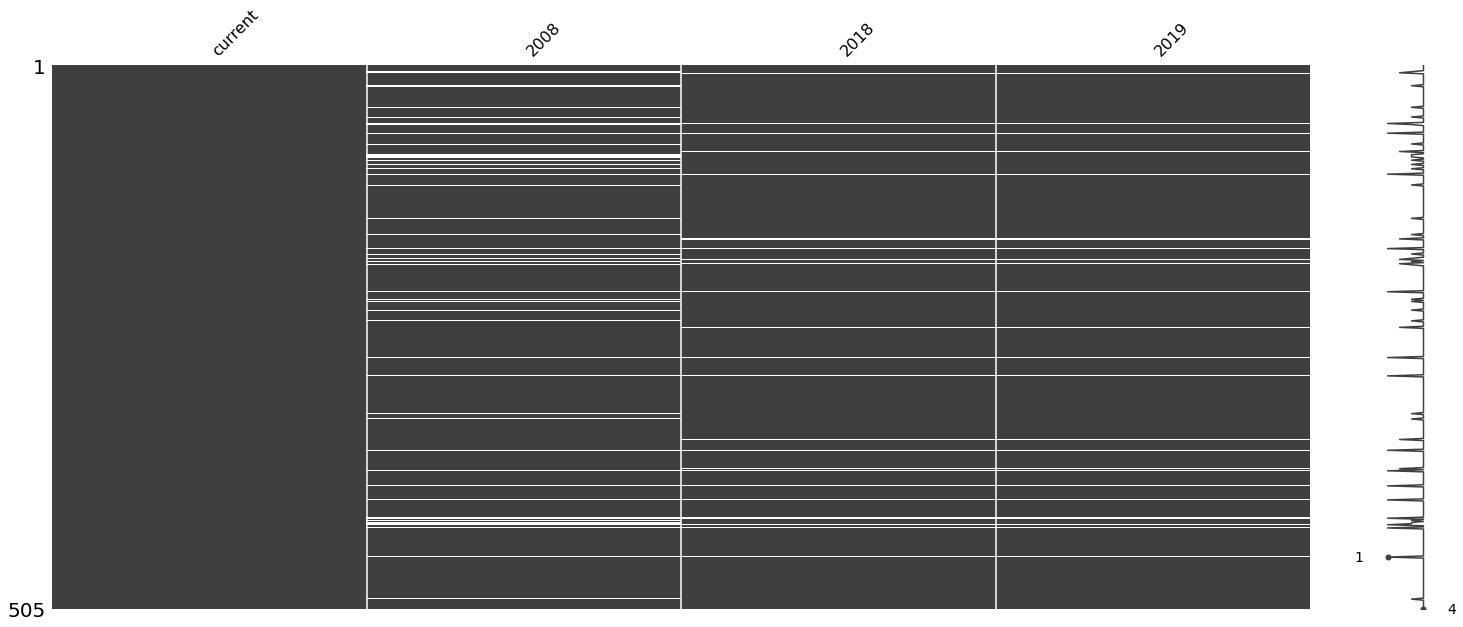

In [408]:
import missingno as msno
msno.matrix(compare)

**Conclusion**: 

Um..... This doesn't seem a good way to build our S&P 500 historic composition as there are many stocks missing compared to the current composition of the S&P 500.

---

## Reverse: We construct the S&P 500 composition from present day to before

### Let's build the composition of S&P 500 from bottom up

In [394]:
dictionary = {}
# The latest S&P 500 composition (https://www.slickcharts.com/sp500)
l = snp500_current[0].Symbol.to_list()

for d in x.index.levels[0][:-51:-1]:
    if 'added_ticker' in x.loc[pd.to_datetime(d),:].index:
        removed_stock_list = [s.upper() for s in x.loc[(pd.to_datetime(d), 'added_ticker'), 'value'].values]
    else:
        removed_stock_list = []
    
    if 'removed_ticker' in x.loc[pd.to_datetime(d),:].index:
        added_stock_list = [s.upper() for s in x.loc[(pd.to_datetime(d), 'removed_ticker'), 'value'].values]
    else:
        added_stock_list = []

    print(d)
    print(len(l), ' + ', len(added_stock_list), ' - ', len(removed_stock_list), end='')

    l = [x.upper() for x in (l + added_stock_list) if x not in removed_stock_list]
    l = list(set(l))
    
    print(' = ', len(l), end='\n----------\n')
    
    dictionary[d] = l

2021-01-21 00:00:00
505  +  0  -  1 =  504
----------
2021-01-07 00:00:00
504  +  0  -  1 =  503
----------
2020-12-21 00:00:00
503  +  1  -  1 =  503
----------
2020-10-12 00:00:00
503  +  1  -  0 =  504
----------
2020-10-09 00:00:00
504  +  0  -  1 =  503
----------
2020-10-07 00:00:00
503  +  1  -  1 =  503
----------
2020-09-21 00:00:00
503  +  3  -  3 =  503
----------
2020-06-22 00:00:00
503  +  3  -  3 =  503
----------
2020-05-22 00:00:00
503  +  1  -  1 =  503
----------
2020-05-12 00:00:00
503  +  2  -  2 =  503
----------
2020-04-06 00:00:00
503  +  2  -  0 =  505
----------
2020-04-03 00:00:00
505  +  0  -  2 =  503
----------
2020-03-03 00:00:00
503  +  1  -  2 =  503
----------
2020-01-28 00:00:00
503  +  1  -  1 =  503
----------
2019-12-23 00:00:00
503  +  3  -  3 =  503
----------
2019-12-09 00:00:00
503  +  1  -  1 =  503
----------
2019-12-05 00:00:00
503  +  1  -  1 =  503
----------
2019-11-21 00:00:00
503  +  1  -  1 =  503
----------
2019-10-03 00:00:00
503  +  

And here's what we have:

In [420]:
e = pd.DataFrame([dictionary], index=['ticker']).T
e['num'] = e.apply(lambda x: len(x['ticker']), axis=1)
e.head()

,ticker,num
2021-01-21,"[PEAK, IBM, TROW, AWK, DHR, ES, FOXA, MPWR, VF...",504
2021-01-07,"[PEAK, IBM, TROW, AWK, DHR, ES, FOXA, MPWR, VF...",503
2020-12-21,"[PEAK, IBM, TROW, AWK, DHR, ES, FOXA, MPWR, VF...",503
2020-10-12,"[PEAK, IBM, TROW, AWK, DHR, ES, FOXA, MPWR, VF...",504
2020-10-09,"[PEAK, IBM, TROW, AWK, DHR, ES, FOXA, MPWR, VF...",503


By looking at the total number of the composition of S&P 500, the number stays in the range of around 500 very consistently. Hence, this method seems much more reliable than our previous method.

As the last step to wrap up this session, we're going to slightly reorganize the data we have acquired and make it more intuitive to check and to utilize.

---

## How to build your historic S&P 500 composition
Let's define the scaffold of the DataFrame we're going to use by defining:
1. start date
2. end date
3. then constructing the `DatetimeIndex` from the start date and end date
4. build the DataFrame scaffold

In [395]:
START_DATE = '2018-1-1'
END_DATE = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [422]:
# Use 'B' to find the dates that are business days
pd.date_range(START_DATE,END_DATE, freq = 'B')

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
               '2021-02-05', '2021-02-08', '2021-02-09', '2021-02-10',
               '2021-02-11', '2021-02-12'],
              dtype='datetime64[ns]', length=815, freq='B')

In [397]:
# Business Day
test = pd.DataFrame(index=pd.date_range(START_DATE,END_DATE, freq = 'B'))

# business month start frequency
# test = pd.DataFrame(index=pd.date_range(START_DATE,END_DATE, freq = 'BMS'))

In [421]:
test['ticker'] = pd.DataFrame([dictionary]).T
z = test.ffill().dropna()
z['num'] = z.apply(lambda x: len(x['ticker']), axis=1)
z.explode('ticker').reset_index().sort_values(['index', 'ticker']).set_index(['index', 'ticker'])

num
index      ticker     
2018-01-03 A       503
           AAL     503
           AAP     503
           AAPL    503
           ABBV    503
...                ...
2021-02-12 YUM     504
           ZBH     504
           ZBRA    504
           ZION    504
           ZTS     504

[409058 rows x 1 columns]

Done! Now we can concat or merge any data such as close price or any other fundamental data.

---

## Reference
- [The S&P 500 Historical Components & Changes](https://analyzingalpha.com/sp500-historical-components-and-changes)
- [List of S&P 500 companies - Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)
- [S&P 500 Companies by Weight](https://www.slickcharts.com/sp500)
- [Some other people prepared this json file of S&P 500 historic composition](https://gist.github.com/kafkasl/078f2c65c4299d367b57c9835b34c333)

*PS: You need VPN to access the Wikipedia page*